# Intro to Data Science Course Project
## Solar Flare Data

In [212]:
#packages
from pylab import *
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

%matplotlib inline

# The data set includes conditions in an area on the sun during 24 hours (features) and how many solar flares of different classes occured (target).

## The features are:
* spot_class: Classification for configuration of group of sunspots
* l_spot_size: Classification for the largest sunspot in the group
* spot_dist: Classification for the distribution of the sunspots
 * spot_class, l_spot_size, spot_dist classification letters aren't ordered in any intuitive way, here's a nice image to show what they mean ![alt text](https://www.spaceweatherlive.com/images/help/zonnevlekken_malde/zonnevlekclassificatie.jpg)
* activity: How has the sunspot activity changed? (1/reduced, 2/unchanged)
* evolution: How have the sunspots evolved? (1/decay, 2/no growth, 3/growth)
* prev_activity: Were there any large flares in the last 24 hours? (1 = nothing as big an an M1, 2 = one M1, 3 = more than one M1)
* hist_complex: Has this region been complex? (1/yes, 2/no)
* hist_complex_recent: Did this region become complex on this pass across sun's disk? (1/yes, 2/no)
* area: Area of sunspots (1/small, 2/large)
* l_area: Area of largest spot (1 means <=5, 2 means >5)

### I don't know how to deal with the number of flares that occured, so I'm only counting if a flare of a certain class occurred.


In [213]:
#open that data up
#there is no header, so create column names
columns = ['spot_class','l_spot_size','spot_dist','activity','evolution','prev_activity','hist_complex','hist_complex_recent','area','l_area','c_class','m_class','x_class']
sfdf = pd.read_table('flare.data2.txt',delim_whitespace=1,skiprows=1,header=None,names=columns)
sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,l_area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,H,R,X,1,2,1,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,1,0,0,0


### Since I'm ignoring the number of flares that occur for each class, it won't really work if I have a lot of observations where multiple classes of flares occurred, luckily that isn't the case.

In [214]:
#are there ever more than one type of flare? 
for index,row in sfdf.iterrows():
    if row['c_class']!= 0 and row['m_class']!=0 and row['x_class']!=0:
        print index,row[-3:]
        sfdf.drop(index,inplace=1)
#only happened once, so let's just drop that        

960 c_class    1
m_class    3
x_class    2
Name: 960, dtype: object


### Looks like there's something weird with the area of the largest spot size..

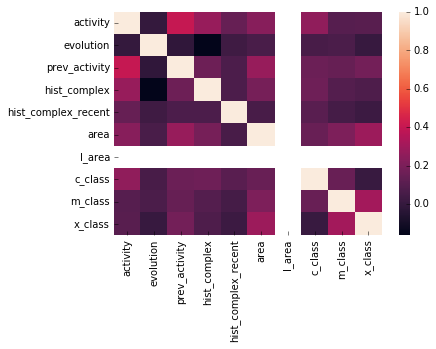

In [215]:
sns.heatmap(sfdf.corr())

In [216]:
#looks like largest area of sunspot always ==1, so no info here
print len(sfdf.index),sum(sfdf.l_area==1)

1065 1065


In [217]:
sfdf.drop('l_area',inplace=1,axis=1)
sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,0,0,0
2,C,S,O,1,3,1,1,2,1,0,0,0
3,H,R,X,1,2,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,0,0,0


### I have a bunch of categorical data, so I need to reformat it into a way the classifier can understand. I replace the classes with dummy features, and make a new column that has a numeric label for the type of flare that occurred during that observation (which will be the target).

In [218]:
#replace categorical features with dummy features, if ordered though leave as numbers
sfdf_clean = sfdf.copy()

#replace sunspot class w/ dummies
#get dummmy features
scd = pd.get_dummies(sfdf.spot_class).astype(int)
#drop the last feature, so absence of the other features means this feature.
scd.drop(scd.columns[-1],inplace=1,axis=1)
#rename the columns so they make sense in the whole df
scd.columns = ['sc_%s' %i for i in scd.columns]
#add dummy features to df
sfdf_clean = pd.concat([sfdf_clean,scd],axis=1)
#drop old feature
sfdf_clean.drop('spot_class',inplace=1,axis=1)

#replace spot size w/ dummies
ssd = pd.get_dummies(sfdf.l_spot_size).astype(int)
ssd.drop(ssd.columns[-1],inplace=1,axis=1)
ssd.columns = ['lss_%s' %i for i in ssd.columns]
sfdf_clean = pd.concat([sfdf_clean,ssd],axis=1)
sfdf_clean.drop('l_spot_size',inplace=1,axis=1)

#replace spot dist w/ dummies
sdd = pd.get_dummies(sfdf.spot_dist).astype(int)
sdd.drop(sdd.columns[-1],inplace=1,axis=1)
sdd.columns = ['sd_%s' %i for i in sdd.columns]
sfdf_clean = pd.concat([sfdf_clean,sdd],axis=1)
sfdf_clean.drop('spot_dist',inplace=1,axis=1)

#replace historically-complex w/ dummies
hcd = pd.get_dummies(sfdf.hist_complex).astype(int)
hcd.drop(hcd.columns[-1],inplace=1,axis=1)
hcd.columns = ['hc_%s' %i for i in hcd.columns]
sfdf_clean = pd.concat([sfdf_clean,hcd],axis=1)
sfdf_clean.drop('hist_complex',inplace=1,axis=1)

#replace hist-complex-recent w/ dummies
hcrd = pd.get_dummies(sfdf.hist_complex_recent).astype(int)
hcrd.drop(hcrd.columns[-1],inplace=1,axis=1)
hcrd.columns = ['hcr_%s' %i for i in hcrd.columns]
sfdf_clean = pd.concat([sfdf_clean,hcrd],axis=1)
sfdf_clean.drop('hist_complex_recent',inplace=1,axis=1)

#make new target column
#target (class of flare) = 0 (no flare), 1 (C-class), 2 (M-class), 3 (X-class)
sfdf_clean['solar_flare'] = zeros(len(sfdf.index),dtype=int)
for index, row in sfdf_clean.iterrows():
    if sum(row[5:8] ==0) ==3:
        sfdf_clean.loc[index,'solar_flare'] = 0
    if row['c_class'] != 0:
        sfdf_clean.loc[index,'solar_flare'] = 1
    if row['m_class'] != 0:
        sfdf_clean.loc[index,'solar_flare'] = 2
    if row['x_class'] != 0:
        sfdf_clean.loc[index,'solar_flare'] = 3        

sfdf_clean.drop(['c_class','m_class','x_class'],inplace=1,axis=1)    
sfdf_clean.head()

,activity,evolution,prev_activity,area,sc_B,sc_C,sc_D,sc_E,sc_F,lss_A,lss_H,lss_K,lss_R,lss_S,sd_C,sd_I,sd_O,hc_1,hcr_1,solar_flare
0,1,3,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,1,3,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0
2,1,3,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0
3,1,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
4,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [219]:
#make a cleaned up data frame for plotting
sfdfp = pd.concat([sfdf,sfdf_clean['solar_flare']],axis=1)
number = preprocessing.LabelEncoder()
sfdfp['spot_class'] = number.fit_transform(sfdfp['spot_class'].astype('str'))
sfdfp['l_spot_size'] = number.fit_transform(sfdfp['l_spot_size'].astype('str'))
sfdfp['spot_dist'] = number.fit_transform(sfdfp['spot_dist'].astype('str'))
sfdfp.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,c_class,m_class,x_class,solar_flare
0,5,0,3,1,3,1,1,1,1,0,0,0,0
1,2,3,2,1,3,1,1,2,1,0,0,0,0
2,1,4,2,1,3,1,1,2,1,0,0,0,0
3,5,3,3,1,2,1,1,1,1,0,0,0,0
4,5,4,3,1,1,1,1,2,1,0,0,0,0


### Let's visualize that data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a18c290>]], dtype=object)

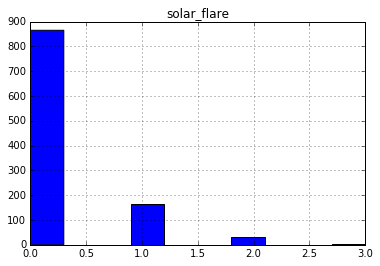

In [226]:
#hardly any x-class, a ton of 'no flares'
sfdfp.hist(column='solar_flare')

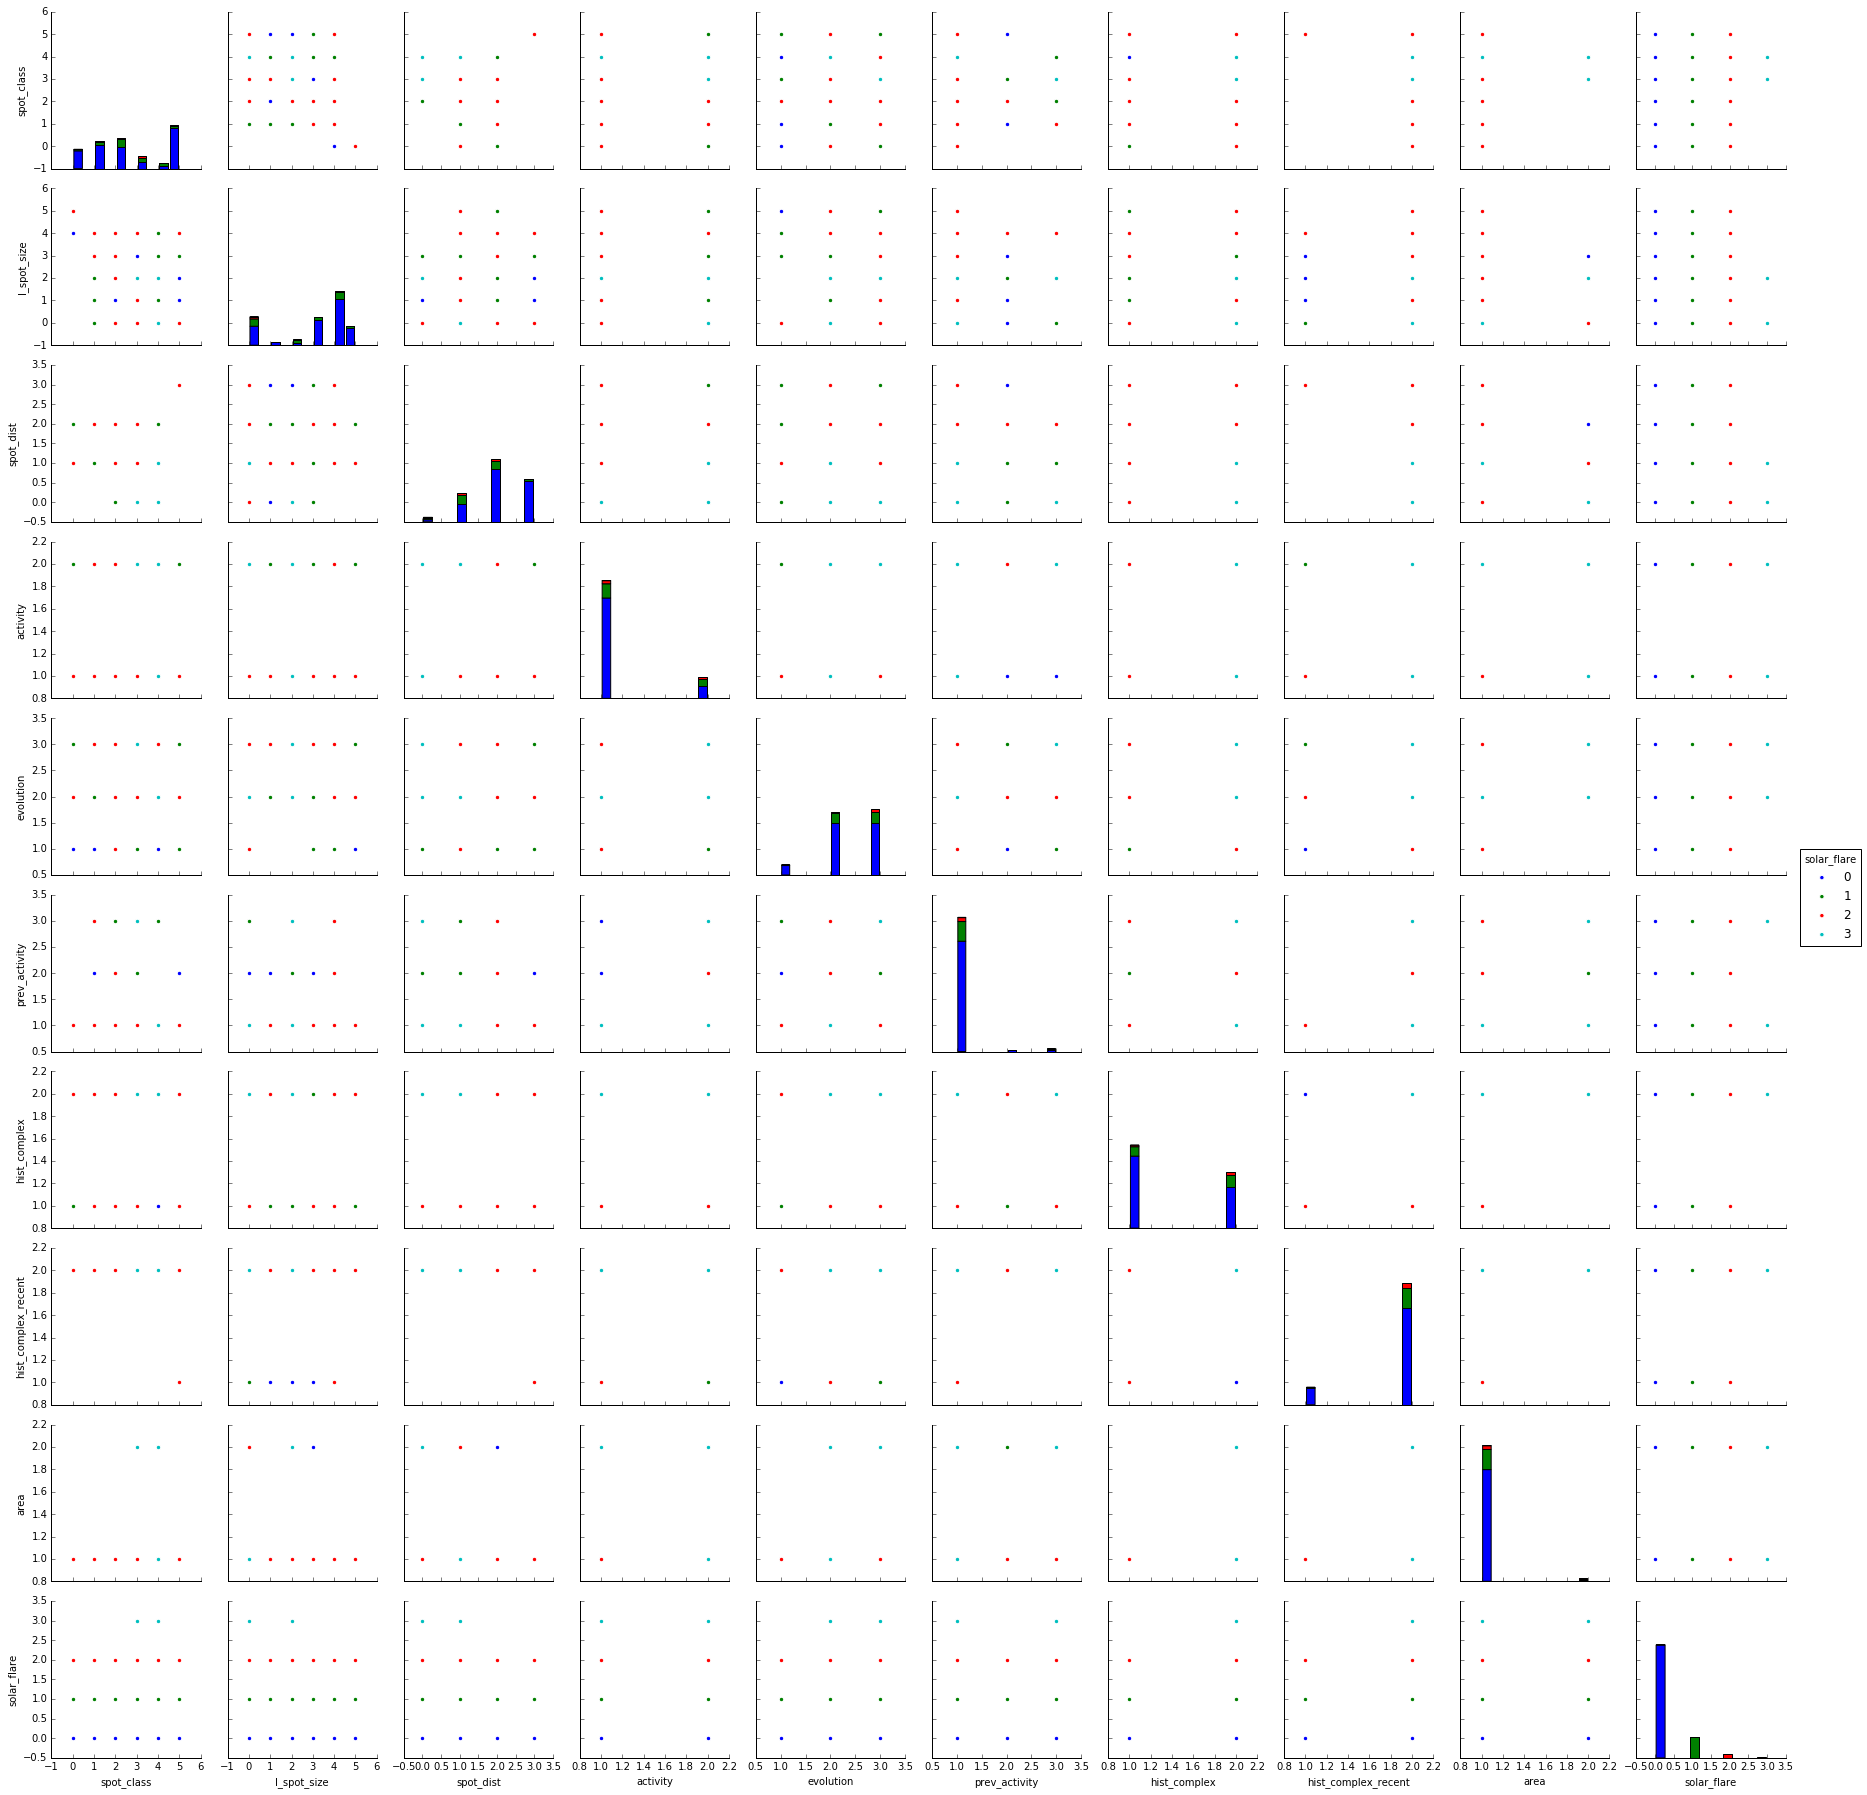

In [221]:
pcols = ['spot_class', 'l_spot_size', 'spot_dist', 'activity', 'evolution', 'prev_activity', 'hist_complex', 'hist_complex_recent', 'area', 'solar_flare']
sns.pairplot(data=sfdfp[pcols],hue='solar_flare')

In [236]:
#wow this is so slow
'''fig = figure()
s = 1
for i,j in enumerate(pcols[-3:]):
    for k,l in enumerate(pcols[-3:]):
        print i,k,j,l
        if k != i:
            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)
            sns.swarmplot(x=j,y=l,hue='solar_flare',data=sfdfp,ax=ax1)
            ax1.set_xlabel(j)
            ax1.set_ylabel(l)
            s+=1
        if k==i:
            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)
            sfdfp.hist(column=pcols[i],ax=ax1)           
            ax1.set_xlabel(j)
            s+=1
'''            

"fig = figure()\ns = 1\nfor i,j in enumerate(pcols[-3:]):\n    for k,l in enumerate(pcols[-3:]):\n        print i,k,j,l\n        if k != i:\n            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)\n            sns.swarmplot(x=j,y=l,hue='solar_flare',data=sfdfp,ax=ax1)\n            ax1.set_xlabel(j)\n            ax1.set_ylabel(l)\n            s+=1\n        if k==i:\n            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)\n            sfdfp.hist(column=pcols[i],ax=ax1)           \n            ax1.set_xlabel(j)\n            ax1.set_ylabel(l)\n            s+=1\n"

spot_class
l_spot_size
spot_dist
activity
evolution
prev_activity
hist_complex
hist_complex_recent
area


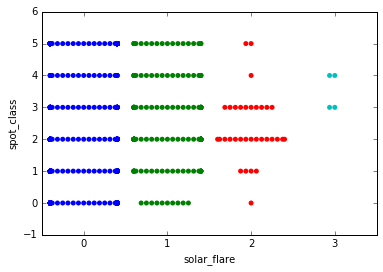

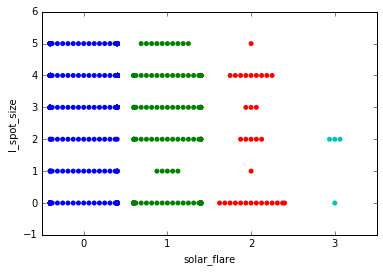

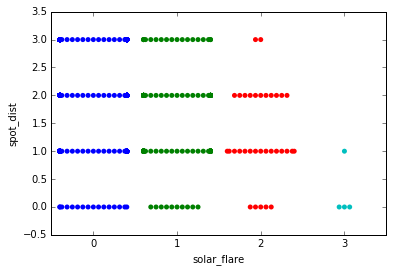

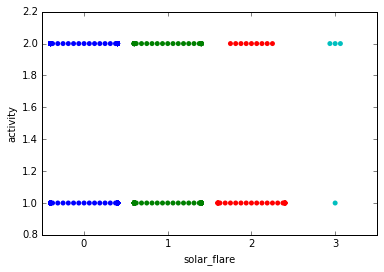

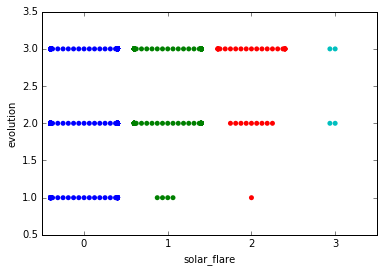

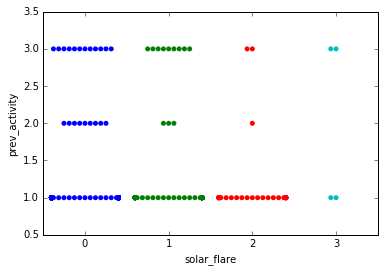

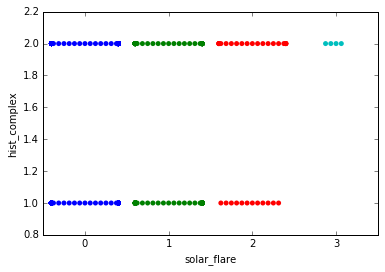

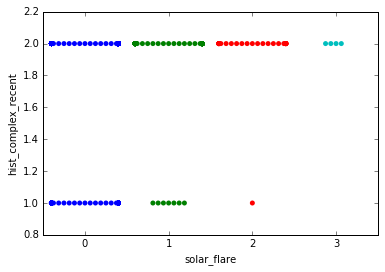

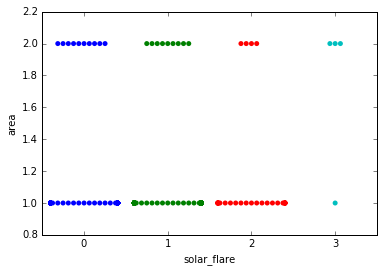

In [239]:
for i in pcols[:-1]:
    print i
    figure()
    sns.swarmplot(x='solar_flare',y=i,data=sfdfp)

In [240]:
#get training/test sets
cols = sfdf_clean.columns[sfdf_clean.columns!='solar_flare']
X = sfdf_clean[cols]
y = sfdf_clean.solar_flare
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [241]:
#fit logistic regression classifier
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train,y_train)
print 'accuracy w/ train data =', logreg.score(X_train,y_train)
print 'accuracy w/ test data =', logreg.score(X_test,y_test)
print(metrics.classification_report(y_test,logreg.predict(X_test)))
#try w/ cross validation
#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(logreg,X,y,cv=4)
print 'cross validation'
print "4-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)

accuracy w/ train data = 0.805764411028
accuracy w/ test data = 0.857677902622
             precision    recall  f1-score   support

          0       0.86      1.00      0.92       228
          1       0.67      0.07      0.12        30
          2       0.00      0.00      0.00         9

avg / total       0.81      0.86      0.80       267

cross validation
4-fold accuracies:
[ 0.80970149  0.80451128  0.81954887  0.79622642]
Mean cv-accuracy: 0.807497014502
Std of cv-accuracy: 0.00845647723952


In [242]:
#examine coefficients
list(zip(cols, logreg.coef_[0]))

[('activity', -0.23301564862034299),
 ('evolution', -0.13130396346582945),
 ('prev_activity', -0.12524998704738918),
 ('area', 0.64209474282093604),
 ('sc_B', 0.69086281692825646),
 ('sc_C', -0.11303522194665597),
 ('sc_D', -0.57069558377352714),
 ('sc_E', -0.89025166980266968),
 ('sc_F', -0.92313281179237194),
 ('lss_A', 0.34094523513878722),
 ('lss_H', 0.30642426342215212),
 ('lss_K', -0.87760121301856253),
 ('lss_R', 0.78357114144161133),
 ('lss_S', 0.52872527717126183),
 ('sd_C', -0.68964295107710538),
 ('sd_I', -0.81430328705458865),
 ('sd_O', -0.30230623225530151),
 ('hc_1', 0.0002329122852911781),
 ('hcr_1', 0.48578609186326199)]

In [243]:
#try w/ random forest
#Random forest of 500 trees
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
print 'accuracy w/ train data =', rf.score(X_train,y_train)
print 'accuracy w/ test data =', rf.score(X_test,y_test)
print metrics.classification_report(y_test,rf.predict(X_test))

cross_val_scores = cross_val_score(logreg,X,y,cv=4)
print 'cross validation' 
print "4-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)

accuracy w/ train data = 0.867167919799
accuracy w/ test data = 0.835205992509
             precision    recall  f1-score   support

          0       0.89      0.93      0.91       228
          1       0.37      0.33      0.35        30
          2       0.00      0.00      0.00         9

avg / total       0.80      0.84      0.82       267

cross validation
4-fold accuracies:
[ 0.80970149  0.80451128  0.81954887  0.79622642]
Mean cv-accuracy: 0.807497014502
Std of cv-accuracy: 0.00845647723952


### It looks like evolution (if the sunspot has become larger/smaller/unchanged) and activity ( were the most important features. 

In [244]:
#how important is each feature
list(zip(sfdf_clean[cols], rf.feature_importances_))

[('activity', 0.096588950293581638),
 ('evolution', 0.15069769138431016),
 ('prev_activity', 0.091978473425207818),
 ('area', 0.020969860838763836),
 ('sc_B', 0.0091220260654722961),
 ('sc_C', 0.020045260159631779),
 ('sc_D', 0.054662133695478843),
 ('sc_E', 0.059190372353982758),
 ('sc_F', 0.025920322529019647),
 ('lss_A', 0.062925222253762028),
 ('lss_H', 0.012077407720773953),
 ('lss_K', 0.06826437622365239),
 ('lss_R', 0.017396736860814537),
 ('lss_S', 0.037884496423216549),
 ('sd_C', 0.029543026651813253),
 ('sd_I', 0.092760159948257398),
 ('sd_O', 0.045406556268591226),
 ('hc_1', 0.088633944156794542),
 ('hcr_1', 0.01593298274687539)]